In [1]:
# library
# standard library
import os
 
# third-party library
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
import dlc_practical_prologue as helper

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = helper.generate_pair_sets(1000)

Processing...
Done!


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=3),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3 , 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 2 * 2, 10)   # fully connected layer, output 10 classes
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output, x    # return x for visualization  
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)


# Training


In [24]:
mini_batch_size=100
EPOCH = 50
LR = 0.005              # learning rate
step = 0

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
criterion = nn.CrossEntropyLoss()                       # the target label is not one-hotted

for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        
        x_tr = train_input.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
        y_tr = train_classes.narrow(0, b, mini_batch_size).narrow(1, 0, 1).squeeze()
        x_tr = Variable(x_tr)   # batch x
        y_tr = Variable(y_tr)   # batch y
        
        output,_ = cnn(x_tr)               # cnn output
        loss = criterion(output, y_tr)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
    x_te = test_input.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
    y_te = test_classes.narrow(0, b, mini_batch_size).narrow(1, 0, 1).squeeze()
    x_te = Variable(x_te)   
    y_te = Variable(y_te)   

    
    y_tr_pred = torch.max(output, 1)[1].data.squeeze()
    acc_tr = (y_tr_pred == y_tr).sum().data.item() / y_tr.size(0)
    
    test_output, last_layer = cnn(x_te)    
    y_te_pred = torch.max(test_output, 1)[1].data.squeeze()
    acc_te = (y_te_pred == y_te).sum().data.item() / y_te.size(0)
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| train accuracy: %.2f' % acc_tr, '| test accuracy: %.2f' % acc_te)


Epoch:  0 | train loss: 0.1083 | train accuracy: 0.97 | test accuracy: 0.90
Epoch:  1 | train loss: 0.0779 | train accuracy: 0.97 | test accuracy: 0.90
Epoch:  2 | train loss: 0.0720 | train accuracy: 0.97 | test accuracy: 0.94
Epoch:  3 | train loss: 0.0407 | train accuracy: 0.98 | test accuracy: 0.90
Epoch:  4 | train loss: 0.0097 | train accuracy: 1.00 | test accuracy: 0.91
Epoch:  5 | train loss: 0.3337 | train accuracy: 0.90 | test accuracy: 0.94
Epoch:  6 | train loss: 0.0388 | train accuracy: 0.98 | test accuracy: 0.95
Epoch:  7 | train loss: 0.0417 | train accuracy: 0.99 | test accuracy: 0.95
Epoch:  8 | train loss: 0.0002 | train accuracy: 1.00 | test accuracy: 0.93
Epoch:  9 | train loss: 0.0015 | train accuracy: 1.00 | test accuracy: 0.93
Epoch:  10 | train loss: 0.0001 | train accuracy: 1.00 | test accuracy: 0.93
Epoch:  11 | train loss: 0.0000 | train accuracy: 1.00 | test accuracy: 0.96
Epoch:  12 | train loss: 0.0001 | train accuracy: 1.00 | test accuracy: 0.96
Epoch:  1

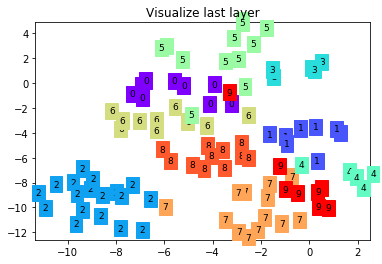

In [25]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = y_te.numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)
plt.ioff()


----